In [4]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np

import csv

data = open('../data.csv', 'r').readlines()
fieldnames = ['x', 'y', 'z', 'unmasked', 'synapses']
reader = csv.reader(data)
reader.next()

rows = [[int(col) for col in row] for row in reader]

sorted_x = sorted(list(set([r[0] for r in rows])))
sorted_y = sorted(list(set([r[1] for r in rows])))
sorted_z = sorted(list(set([r[2] for r in rows])))

vol = np.zeros((len(sorted_x), len(sorted_y), len(sorted_z)))
for r in rows:
    if r[-2] != 0:
        vol[sorted_x.index(r[0]), sorted_y.index(r[1]), sorted_z.index(r[2])] = r[-1]


### 1. See how Synapse Density in a Layer Varies in the X, Y, Z directions
(Fixed issue from last time, not throwing out unmasked == 0)

Note:
It looks like there are evident local minima that may define cortex layers. In the plot for density across the y-layer, we see that there are 4 defined local minima that may be cortex layer boundaries. 

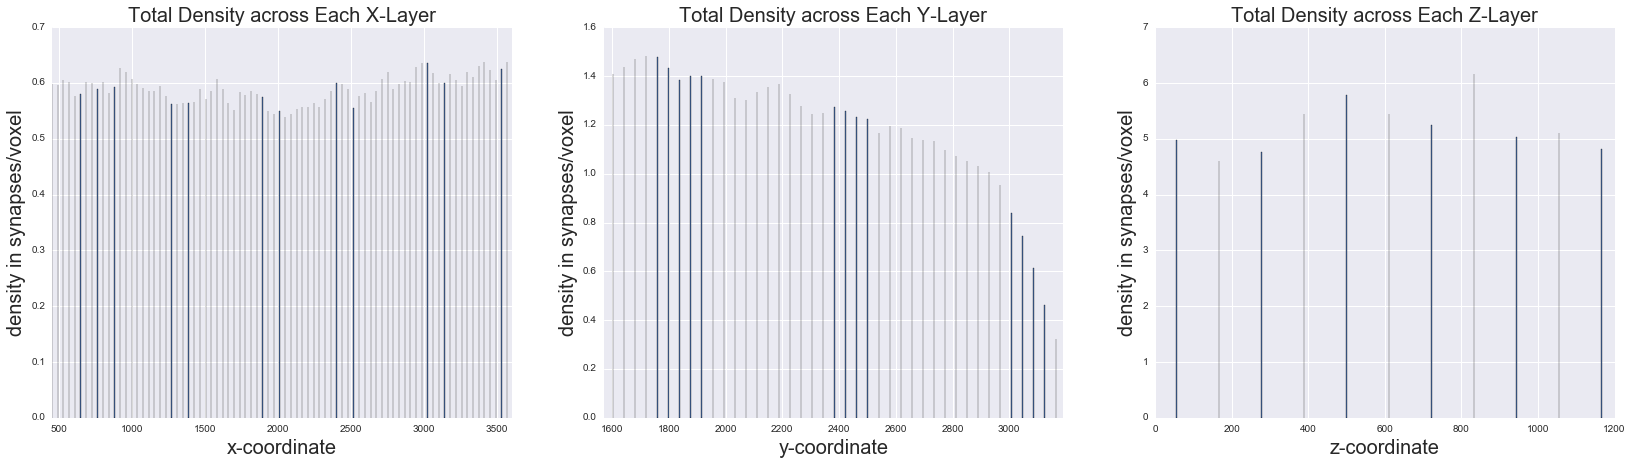

In [11]:
synden = np.zeros((len(sorted_x), len(sorted_y), len(sorted_z)))
for r in rows:
    if r[-2] != 0:
        synden[sorted_x.index(r[0]), sorted_y.index(r[1]), sorted_z.index(r[2])] = np.float(r[-1])/np.float(r[-2])

x_sum = [0] * len(synden[:,0,0])
for i in range(len(synden[:,0,0])):
    x_sum[i] = sum(sum(synden[i,:,:]))
    
y_sum = [0] * len(synden[0,:,0])
for i in range(len(synden[0,:,0])):
    y_sum[i] = sum(sum(synden[:,i,:]))
    
z_sum = [0] * len(synden[0,0,:])
for i in range(len(synden[0,0,:])):
    z_sum[i] = sum(sum(synden[:,:,i]))
    
unique_x = np.unique(sorted_x)
unique_y = np.unique(sorted_y)
unique_z = np.unique(sorted_z)

plt.figure()
plt.figure(figsize=(28,7))

plt.subplot(131)
plt.bar(unique_x, x_sum, 1)
plt.xlim(450, 3600)
plt.ylabel('density in synapses/voxel',fontsize=20)
plt.xlabel('x-coordinate',fontsize=20)
plt.title('Total Density across Each X-Layer',fontsize=20)

plt.subplot(132)
plt.bar(unique_y, y_sum, 1)
plt.xlim(1570, 3190)
plt.ylabel('density in synapses/voxel',fontsize=20)
plt.xlabel('y-coordinate',fontsize=20)
plt.title('Total Density across Each Y-Layer',fontsize=20)

plt.subplot(133)
plt.bar(unique_z, z_sum, 1)
plt.ylabel('density in synapses/voxel',fontsize=20)
plt.xlabel('z-coordinate',fontsize=20)
plt.title('Total Density across Each Z-Layer',fontsize=20)

### 2. Looking at the y-layer: can we see cortex layers?

We think that the boundaries between layers may be characterized by the local minima in the second subplot above. We see local maxima that are steadily decreasing as y-increases. The overall direction of increasing density in layers looks like it would have a strong y-component. If we say that the y-regions between local minima are possibly cortex layers, then we may be looking at 5 layers and 4 boundaries near y-coordinates 1800,2100, 2300, and 2550. Let's find the local minima where we believe the cortex layer boundaries may be.

In [12]:
from scipy.signal import argrelextrema
y_local_mins_idcs = np.asarray(argrelextrema(np.asarray(y_sum), np.less))
y_local_mins = [0]*len(y_local_mins_idcs)
for i, y in enumerate(y_local_mins_idcs):
    y_local_mins[i] = unique_y[y_local_mins_idcs[i]]

print "Y local minima: ", y_local_mins[0][3:len(y_local_mins[0])]

Y local minima:  [1837 2071 2305 2539]


### 3. How are synapses distributed within these possible cortex layers? Are they uniform?

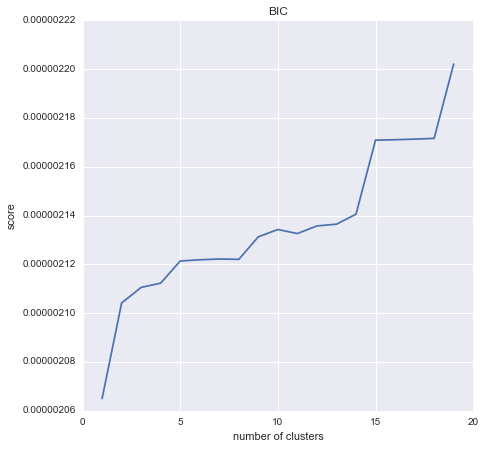

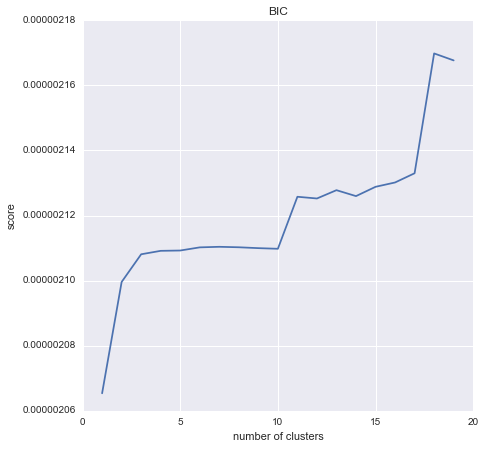

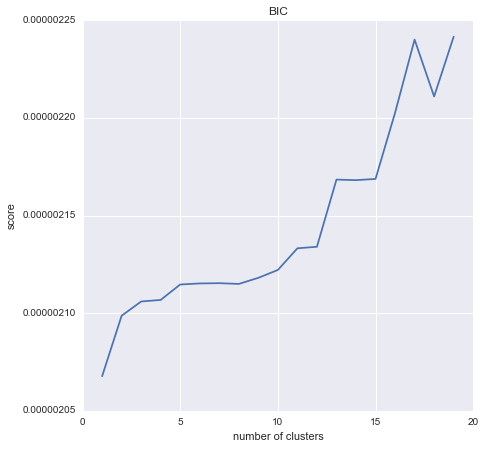

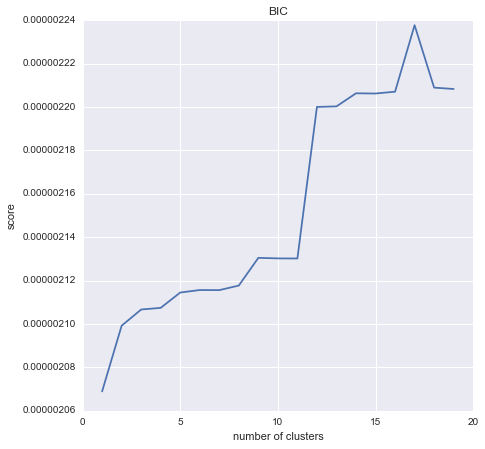

In [18]:
import urllib2
import sklearn.mixture as mixture

url = ('https://raw.githubusercontent.com/Upward-Spiral-Science'
       '/data/master/syn-density/output.csv')
data = urllib2.urlopen(url)
csv = np.genfromtxt(data, delimiter=",")[1:] 

csv_clean = csv[np.logical_not(csv[:,3] == 0)] 
csv_clean = csv_clean[csv_clean[:,0] >= 409]
csv_clean = csv_clean[csv_clean[:,0] <= 3529]
csv_clean = csv_clean[csv_clean[:,1] >= 1564]
csv_clean = csv_clean[csv_clean[:,1] <= 3124]
csv_clean_no_ratio = csv_clean
csv_clean[:,4] = np.divide(csv_clean[:,4],csv_clean[:,3])
csv_clean[:,4] = csv_clean[:,4]*(64**3)

# pull out y-layers
boundaries = y_local_mins[0][2:len(y_local_mins[0])]
for i in range (0,len(boundaries)-1):
    y_layer = csv_clean[np.logical_and(csv_clean[:,1] >= boundaries[i],csv_clean[:,1] <= boundaries[i+1])]
    
    # run bic on the y-layer
    bics = []
    max_clusters = 20
    for i in range(1,30):
        bic = np.array([])
        i = np.array(range(1, max_clusters))
        for idx in range(1, max_clusters):
            gmm = mixture.GMM(n_components=idx, n_iter=1000, covariance_type='diag')
            gmm.fit(y_layer)
            bic = np.append(bic, gmm.bic(y_layer))
        bics.append(bic)
    bic = np.asarray(bics)
    bic_mean = np.max(bic,0)

    plt.figure(figsize=(7,7))
    plt.plot(i, 1.0/bic_mean)
    plt.title('BIC')
    plt.ylabel('score')
    plt.xlabel('number of clusters')
    plt.show()

Surprisingly, it looks like the y-layers derived from our bounds above are not very uniformly distributed at all. From my understanding, it seems that we would expect some uniformity in the cortical layers. This definitely requires further investigation into how the synapse density within the cortex layers is expected to look like.

### 4. Is the spike noise?

Average Density:  0.00134070207006
Std Deviation:  8.46720771375e-05
maxbin 0.00131489435301


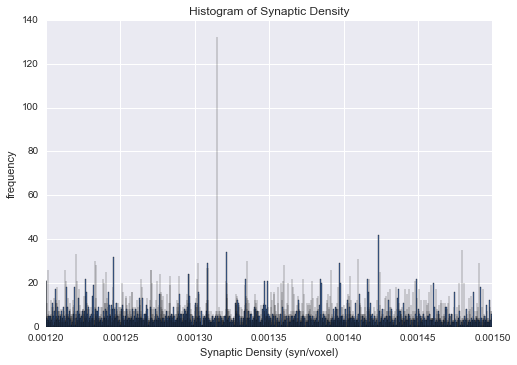

In [7]:
from mpl_toolkits.mplot3d import axes3d
import urllib2

# Original
total_unmasked = 0
total_syn = 0
for r in rows:
    total_unmasked = total_unmasked + r[-2]
    total_unmasked = total_unmasked + r[-1]

np.set_printoptions(precision=3, suppress=True)
url = ('https://raw.githubusercontent.com/Upward-Spiral-Science'
       '/data/master/syn-density/output.csv')
data = urllib2.urlopen(url)
csv = np.genfromtxt(data, delimiter=",")[1:] # don't want first row (labels)

# chopping data based on thresholds on x and y coordinates
x_bounds = (409, 3529)
y_bounds = (1564, 3124)

def check_in_bounds(row, x_bounds, y_bounds):
    if row[0] < x_bounds[0] or row[0] > x_bounds[1]:
        return False
    if row[1] < y_bounds[0] or row[1] > y_bounds[1]:
        return False
    if row[3] == 0:
        return False
    
    return True

indices_in_bound, = np.where(np.apply_along_axis(check_in_bounds, 1, csv, x_bounds, y_bounds))
data_thresholded = csv[indices_in_bound]
n = data_thresholded.shape[0]


def synapses_over_unmasked(row):
    s = (row[4]/row[3])*(64**3)
    return [row[0], row[1], row[2], s]

syn_unmasked = np.apply_along_axis(synapses_over_unmasked, 1, data_thresholded)
syn_normalized = syn_unmasked
a = np.apply_along_axis(lambda x:x[4]/x[3], 1, data_thresholded)

# Spike
spike = a[np.logical_and(a <= 0.0015, a >= 0.0012)]
print "Average Density: ", np.mean(spike)
print "Std Deviation: ", np.std(spike)

# Histogram
n, bins, _ = plt.hist(spike, 2000)
plt.title('Histogram of Synaptic Density')
plt.xlabel('Synaptic Density (syn/voxel)')
plt.ylabel('frequency')

bin_max = np.where(n == n.max())

print 'maxbin', bins[bin_max][0]

Now we know that the "spike" occurs at a synaptic density value of about 0.0013149.

In [8]:
bin_width = bins[1]-bins[0]
syn_normalized[:,3] = syn_normalized[:,3]/(64**3)
spike = syn_normalized[np.logical_and(syn_normalized[:,3] <= 0.00131489435301+bin_width, syn_normalized[:,3] >= 0.00131489435301-bin_width)]
print "There are ", len(spike), " points in the 'spike'"

There are  136  points in the 'spike'


Are the points in the spike uniformly distributed?

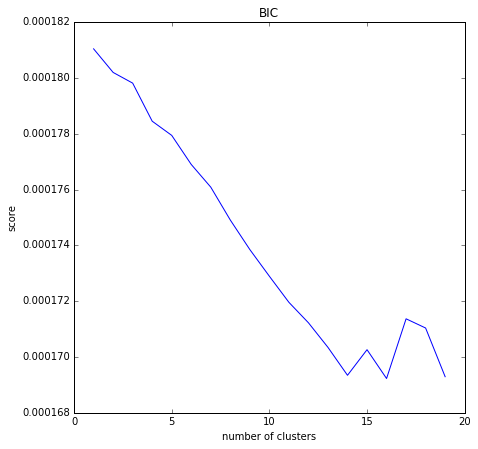

In [109]:
import sklearn.mixture as mixture

bics = []
max_clusters = 20
for i in range(1,30):
    bic = np.array([])
    i = np.array(range(1, max_clusters))
    for idx in range(1, max_clusters):
        gmm = mixture.GMM(n_components=idx, n_iter=1000, covariance_type='diag')
        gmm.fit(spike)
        bic = np.append(bic, gmm.bic(spike))
    bics.append(bic)
bic = np.asarray(bics)
bic_mean = np.max(bic,0)

plt.figure(figsize=(7,7))
plt.plot(i, 1.0/bic_mean)
plt.title('BIC')
plt.ylabel('score')
plt.xlabel('number of clusters')
plt.show()

It does look as if the optimal number of clusters for the spike is 0. Thus, the spike may likely be uniformly distributed and we suspect it may be noise.

### 5. If we smooth our data, is the spike still there?

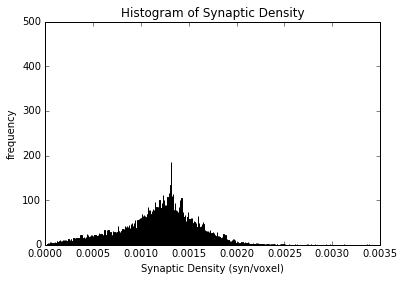

In [140]:
from scipy import ndimage as nd
smoothed = nd.filters.gaussian_filter(data_thresholded,1)
a = np.apply_along_axis(lambda x:x[4]/x[3], 1, data_thresholded)

# Histogram
n, bins, _ = plt.hist(a, 2000)
plt.title('Histogram of Synaptic Density')
plt.xlabel('Synaptic Density (syn/voxel)')
plt.ylabel('frequency')

The spike still shows up when we smooth our data with a Gaussian filter, so it may not be noise after all.